# Packages

In [1]:
#basic packages
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

#data pre-processing packages
from datetime import datetime


#results and analysis packages
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# data modelling & results
from yellowbrick.regressor import PredictionError, ResidualsPlot
from sklearn.model_selection import train_test_split
import math as math

#NN
import xgboost as xgb

from tensorflow import keras
from keras.utils.vis_utils import plot_model
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#feature importance
import shap


# Script

## Error computation

In [3]:
#defining the Root Mean Squared Error

def rmse(y_true, y_predicted):
    
    return np.sqrt(mean_squared_error(y_true, y_predicted))

In [4]:
#errors computation

def errors_computation(data):
    
    df=pd.DataFrame()
    #df.at['RMSE (as root mean)', 'Wind']= round(rmse(data['Target'], data['WS_pred']), 3)
    df.at['MAE (in avg)', 'Wind']= round(mae(data['Target'], data['WS_pred']), 3)
    df.at['MAPE (%)', 'Wind']= round(mape(data['Target'], data['WS_pred'])*100, 3)
    
    #df.at['RMSE (as root mean)', 'Power']= round(rmse(data['P'], data['P_pred']), 3)
    df.at['MAE (in avg)', 'Power']= round(mae(data['P'], data['P_pred']), 3)
    df.at['MAPE (%)', 'Power']= round(mape(data['P'], data['P_pred'])*100, 3)
    
    
    print('Wind RMSE: ', round(rmse(data['Target'], data['WS_pred']), 3), 'm/s as root mean')
    print('Wind MAE: ', round(mae(data['Target'], data['WS_pred']), 3), 'm/s in avg')
    print('Wind MAPE: ', round(mape(data['Target'], data['WS_pred'])*100, 3), '%')
    
    print('Power RMSE: ', round(rmse(data['P'], data['P_pred']), 3), 'kW as root mean')
    print('Power MAE: ', round(mae(data['P'], data['P_pred']), 3), 'kW in avg')
    print('Power MAPE: ', round(mape(data['P'], data['P_pred'])*100, 3), '%')
    
    return df

In [5]:
def error_plot(data, title):
    
    #title is expected to be an str
    #WS_pred and Target should be the variables names

    #plotting the reference
    plt.figure(figsize=(12,8))
    plt.plot([-1,17.5],[-1,17.5], 'green', linewidth=4, alpha=.12)
    plt.plot(data['WS_pred'], data['Target'], marker='o', ls='', label='Regression', markersize=5, alpha=.1)


    plt.legend()

    ax=plt.gca()
    ax.set(xlabel='y predicted', ylabel='y actual');
    ax.set_title(title)
    ax.set_ylim(ymin=4, ymax=17.5)
    ax.set_xlim(xmin=4, xmax=17.5)
    
    return print('')

In [6]:
def powercurve_computation(data, power_curve):
    
    from scipy import interpolate
    
    #this function computes the power at a observation given the information at a observation:
    # the WS (in m/s) at the wind turbine location and at the hub height (Target)
    # the power curve of the wind turbine in an xslx
    
    
    x=power_curve['Wind Speed [m/s]']
    y=power_curve['Warranted Power Curve [kW]']
    x_new=data['Target']
    
    f = interpolate.interp1d(x, y)
    #, kind='linear'
    data['P']=f(x_new)
    
    if 'WS_pred' in data.keys():
        x_new2=data['WS_pred']
        data['P_pred']=f(x_new2)
    
    print('power curve computation performed')
    
    return data

In [7]:
def control_power_computation (data_test, data_train, power_curve):
    
    results_test=pd.DataFrame()
    results_train=pd.DataFrame()
    
    
    results_test=powercurve_computation(data_test, power_curve)
    results_train=powercurve_computation(data_train, power_curve)

    return results_test, results_train

In [8]:
def compute_results(data_test, data_train, power_curve, plot_error):
    
    #this function computes and plots the results of a modelling:

    results_test, results_train=control_power_computation (data_test, data_train, power_curve)
    
    
    print('Modelling errors for training set:')
    errors_computation(results_train)
    print('')
    print('Modelling errors for test set:')
    errors_computation(results_test)
    print('')
    
    if plot_error:
        print('')
        error_plot(results_test, 'Error plot for test set wind speed')

    print('')
    return print('Showing the results of the modelling: ')

In [9]:
def compute_results1(data_test, data_train, power_curve, plot_error):
    
    #this function computes and plots the results of a modelling:

    results_test, results_train=control_power_computation (data_test, data_train, power_curve)
    
    
    print('Modelling errors for training set:')
    errors_computation(results_train)
    print('')
    print('Modelling errors for test set:')
    errors_computation(results_test)
    print('')
    print('Modelling errors in AEP terms for test set')
    data=AEP_computation(results_test, power_curve)
    
    if plot_error:
        print('')
        error_plot(results_test, 'Error plot for test set wind speed')

    print('')
    print('Showing the results of the modelling: ')
    return data

In [10]:
def AEP_computation(data, power_curve):
    
    #binning the WS_Pred
    data['WS_pred_bin']=pd.cut(data['WS_pred'],
                                       bins=list(np.arange(-0.25,28.0,0.5)),
                                                 labels=list(np.arange(0.0,28.0,0.5)))

        
    #creating the AEP (Annual Energy Production table)
        
    AEP_table=pd.DataFrame()
    
    AEP_table['WS']=PC['Wind Speed [m/s]']
    AEP_table['WPC']=PC['Warranted Power Curve [kW]']
    AEP_table.set_index('WS', inplace=True)
    AEP_table['MPC_SC']=data.groupby('WS_pred_bin', as_index=True)['P'].mean()

    #puedo rellenar los NaN de MPC_SC copiando lo que tendría que ser: WPC
    
#     for i in AEP_table.index:
#         if math.isnan(AEP_table.at[i, 'MPC_SC']):
#             AEP_table.at[i, 'MPC_SC']=AEP_table.at[i, 'WPC']
    
    AEP_table['WSAD']=power_curve['Wind Speed Distribution [Hr/Year]']
    
    #o igual aquí tendría que cortar la tabla para NaN values
    
#     AEP_table=AEP_table.dropna()
    
    AEP_table['WAEP']=AEP_table['WPC']*AEP_table['WSAD']
    AEP_table['MAEP_SC']=AEP_table['MPC_SC']*AEP_table['WSAD']
    
    #computing the metrics for later printing
    
    MAEP_SC=AEP_table['MAEP_SC'].sum()
    WAEP=AEP_table['WAEP'].sum()
    AEP_perc=(MAEP_SC/WAEP)*100
    AEP_diff=(MAEP_SC-WAEP)/1000
    
    #printing the results

    print('')
    print('The computed AEP_table is: ')
    AEP_table(AEP_table)
    print('')
    print('The AEP% of the Site Calibration is: ', round(AEP_perc, 3), '%')
    print('')
    print('The AEP difference of the Site Calibration is: ', round(AEP_diff, 3), 'MWh')
    print('')
    AEP_plot(data, AEP_table)                                
    
    
    return data

In [11]:
def AEP_plot(data, AEP_table):
    
    #data is expected to contain: Target, WS_pred, P, P_pred
    #AEP_table is expected to contain: WS, WPC, MPC-SC

    #plotting the Power curves
    plt.figure(figsize=(10,6))
    plt.plot(data['WS_pred'], data['P'], marker='o', ls='', label='measured scatter', markersize=5, alpha=.1)
    plt.plot(AEP_table.index, AEP_table['WPC'], marker='o', color='black', linewidth=0.5, label='WPC', markersize=5)
    plt.plot(AEP_table.index, AEP_table['MPC_SC'], marker='o', color='red', linewidth=0.5, label='MPC-SC', markersize=5)


    plt.legend()

    ax=plt.gca()
    ax.set(ylabel='Power interpolated with WPC and Target WS (kW)', xlabel='Predicted Wind Speed (m/s)');
    ax.set_title('Site Calibration Power Curve')
    ax.set_xlim(xmin=0, xmax=20)
#     ax.set_xlim(xmin=0, xmax=27.5)
    
    return print('Error plot performed')

In [12]:
def AEP_table(AEP_table):
    
    #AEP_table is expected to contain: WPC, MPC_SC, WPC, WSAD, WAEP, MAEP
    
    WS= AEP_table.index
    WPC=AEP_table['WPC']
    MPC_SC=round(AEP_table['MPC_SC'],0)
    WSAD=AEP_table['WASD']
    WAEP=round(AEP_table['WAEP']/1000000, 3)
    MAEP=round(AEP_table['MAEP']/1000000, 3)
    

    row_headers=None
    column_headers=('Wind speed bin (m/s)', 'WPC (kW)', 'MPC_SC (kW)',
                    'Annual Wind Distribution (h/year)', 'WAEP (GWh)', 'MAEP (GWh)')

    rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
    ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))

    l_2d=[list(WS), list(WPC), list(MPC), list(WSAD), list(WAEP), list(MAEP)]

    cell_text=np.array(l_2d).T

    fig, ax = plt.subplots(figsize=(12,5)) 
    ax.set_axis_off()

    the_table=ax.table(cellText=cell_text,
                      rowLabels=row_headers,
                      rowColours=rcolors,
                      rowLoc='right',
                      colColours=ccolors,
                      colLabels=column_headers,
                      cellLoc ='center',
                      loc='upper center',
                      colWidths = [0.1] * 5)

    ax.set_title('Annual Energy Production for Site Calibration PC', 
                 fontweight ="bold", fontsize=14) 

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)
    the_table.scale(2, 2)
    
    return ('AEP table printed')

## Data uploading

In [13]:
def uploading_csv(file_folder,file_name):
    
    #file folder required
    #file name required
    #file is expected to be in the data root: r'C:\Users\irgaa\Irma\Data'
    #this function uploads and formats csv/txt/xlsx datasets into DataFrame
    
    
    data_root=r'C:\Users\irgaa\Irma\Data'
    data_folder=str(file_folder)
    data_file=str(file_name)
    
    data_path=data_root+data_folder+data_file
    
    data1 = pd.read_csv(data_path)

    
    # We will save the WD_bin as the index
    
    return data1

In [14]:
#this function saves a data csv

def save (data, file_folder,file_name):
    
    #file folder required
    #file name required
    #file is expected to be saved in the data root: r'C:\Users\irgaa\Irma\Data'
    #this function saves a csv/txt/xlsx into Irma's folder
    #the saved file will keep the columns names but not the index
    
    data_root=r'C:\Users\irgaa\Irma\Data'
    data_folder=str(file_folder)
    data_file=str(file_name)
    
    data_path=data_root+data_folder+data_file
    
    data.to_csv (data_path, index = False, header=True)
    
    
    return print('file', data_file, 'saved in', data_folder, 'folder')

## Data selection

In [15]:
def data_selection(X_train, X_test, inputs):
    
    #this function returns the columns of the training and test sets in the inputs list
    
    X_train1 = pd.DataFrame()
    X_test1 = pd.DataFrame()
    
    
    X_train1 = X_train[inputs]
    X_test1 = X_test[inputs]

    
    return X_train1,X_test1

In [16]:
def data_drop(X_train, X_test, list_2drop):
    
    #this function returns the columns of the training and test sets in the inputs list

    X_train1 = X_train.drop(columns=list_2drop)
    X_test1 = X_test.drop(columns=list_2drop)

    
    
    return X_train1,X_test1

## Modelling

### Modelling XGBoost

In [17]:
def modelling_XGBoost (X, X_test, y, y_test, power_curve,  parameters, plot_error, plot):
    
    #creating the model
    max_depth=parameters['max_depth']
    n_estimators=parameters['n_estimators']
    learning_rate=parameters['learning_rate']
    subsample=parameters['subsample']
    colsample_bytree=parameters['colsample_bytree']
    min_child_weight=parameters['min_child_weight']
    gamma=parameters['gamma']
    reg_lambda=parameters['reg_lambda']
    
 
    model = xgb.XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=42,
                               objective='reg:squarederror', booster='gbtree', learning_rate=learning_rate,
                               subsample=subsample, colsample_bytree=colsample_bytree,
                             min_child_weight=min_child_weight, reg_lambda=reg_lambda)
                               
    #model fitting
    model.fit(X_train, y_train)
        
    
    #model predicting
    y_pred_test=model.predict(X_test)
    y_pred_train=model.predict(X_train)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])
    
    

    #computing the results
    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y['Target']
    
    
    data=compute_results(data_test, data_train, power_curve, plot_error)
    print('XGBoost modelling performed')
    
    return model

### Grid Search XGBoost

In [18]:
def GridSearch_XGBoost (X, X_test, y, y_test, power_curve, parameters, param_grid, plot_error):
    
    
    #counting the runing time
    start_time = time.time()
    
    #creating the model
    max_depth=parameters['max_depth']
    n_estimators=parameters['n_estimators']
    learning_rate=parameters['learning_rate']
    subsample=parameters['subsample']
    colsample_bytree=parameters['colsample_bytree']
    min_child_weight=parameters['min_child_weight']
    gamma=parameters['gamma']
    reg_lambda=parameters['reg_lambda']
    
    #creating the model
    xgbr = xgb.XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=42,
                           objective='reg:squarederror', booster='gbtree', learning_rate=learning_rate,
                           subsample=subsample, colsample_bytree=colsample_bytree,
                         min_child_weight=min_child_weight, gamma=gamma, reg_lambda=reg_lambda)
    
    
    
    #Grid Search CV
    clf = GridSearchCV(estimator=xgbr, 
                             param_grid=param_grid,
                             cv=4,
                             scoring='neg_mean_squared_error',
                             verbose=1) 
    
        
    #model fitting
    clf.fit(X_train, y_train)
    
    
    #model predicting
    
    y_pred_test=clf.predict(X_test)
    y_pred_train=clf.predict(X_train)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])
    
    print('')
    print('Best parameters :')
    print(clf.best_params_)
    print('')

    #computing the results
    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y['Target']
    
    compute_results(data_test, data_train, power_curve, plot_error)
    print('GridSearch_ XGBoost performed')
    print("--- %s minutes ---" % ((time.time() - start_time)/60))
    print('')
    print('Lowest RMSE: ', (-clf.best_score_)**(1/2.0))
    
    
    
    return clf

### Random Search XGBoost

In [19]:
def RandomSearch_XGBoost(X, X_test, y, y_test, power_curve, param_distribs, plot_error):
    
    #counting the runing time
    start_time = time.time()
    
    
    #creating the model
    xgbr = xgb.XGBRegressor(random_state=42)
    
    #Random Search CV
    clf = RandomizedSearchCV(estimator=xgbr, 
                             param_distributions=param_distribs,
                             cv=4,
                             scoring='neg_mean_squared_error',
                             n_iter=25,
                             verbose=1) 
    
    
    #model fitting
    clf.fit(X_train, y_train)
    
    
    #model predicting
    
    y_pred_test=clf.predict(X_test)
    y_pred_train=clf.predict(X_train)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])
    
    print('')
    print('Best parameters :')
    print(clf.best_params_)
    print('')

    #computing the results
    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y['Target']
    
    compute_results(data_test, data_train, power_curve, plot_error)
    print('RandomSearch_ XGBoost performed')
    print("--- %s minutes ---" % ((time.time() - start_time)/60))
    print('')
    print('Lowest RMSE: ', (-clf.best_score_)**(1/2.0))
    
    return clf
    

### Model Testing

In [20]:
def model_testing (X_train, X_test, y_train, y_test, power_curve, model, plot_error):

    

    y_pred_test=model.predict(X_test)
    y_pred_train=model.predict(X_train)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])


    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y_train['Target']
        
    
    compute_results(data_test, data_train, power_curve, plot_error)
    
    WS_pred=data_test['WS_pred']
    print('XGBoost results performed')
    
    return WS_pred

### Feature importance

In [21]:
def feature_importance (X_train, X_test, model):
    
    X_t, X_f, y_t, y_f = train_test_split(X_train,y_train, test_size=0.02, random_state=12)
    
    background = X_f.copy()
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap_obj=explainer(X_test)
    shap.summary_plot(shap_values, X_train, plot_type="bar")
    shap.plots.beeswarm(shap_obj)
    
    
    shap_v=pd.DataFrame(shap_values)
    feature_list=X_test.columns
    shap_v.columns=feature_list
    shap_v=shap_v.abs()
    k=pd.DataFrame(shap_v.mean()).reset_index()
    k.columns=['variables','SHAP_abs']
    k.sort_values(by='variables')
    
    
    
    print('Feature importance through SHAP values performed')
    
    return k

# Data analysis

## Dataset3- WTG18

In [22]:
#upload the dataset with file_folder, file_name
X_train= uploading_csv('\Dataset3-New_Site','\X_train18.csv')
X_test= uploading_csv('\Dataset3-New_Site','\X_test18.csv')
y_train= uploading_csv('\Dataset3-New_Site','\y_train18.csv')
y_test= uploading_csv('\Dataset3-New_Site','\y_test18.csv')

X_test.keys()

Index(['WS1', 'WS3', 'WS4', 'WSHor', 'WDHor', 'WSVer', 'WDVer', 'T1', 'RH1',
       'T2', 'RH2', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WD1', 'WD3', 'WD4',
       'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [23]:
y_test.keys()

Index(['Target'], dtype='object')

In [24]:
PC= uploading_csv('\Dataset3-New_Site','\PC_V150.csv')

### Grid Search

In [27]:
parameters={
    'max_depth':5,
    'n_estimators': 1000,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':1,
    'gamma':0,
    'reg_lambda':1,
}

In [28]:
param_grid={
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
}

In [29]:
 GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 10 candidates, totalling 40 fits

Best parameters :
{'n_estimators': 900}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.067 m/s as root mean
Wind MAE:  0.051 m/s in avg
Wind MAPE:  0.693 %
Power RMSE:  42.578 kW as root mean
Power MAE:  28.332 kW in avg
Power MAPE:  1.821 %

Modelling errors for test set:
Wind RMSE:  0.405 m/s as root mean
Wind MAE:  0.295 m/s in avg
Wind MAPE:  3.918 %
Power RMSE:  237.4 kW as root mean
Power MAE:  153.407 kW in avg
Power MAPE:  9.92 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 10.148249133427937 minutes ---

Lowest RMSE:  0.42452589463134804


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=1000, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,

In [25]:
parameters={
    'max_depth':5,
    'n_estimators': 900,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':1,
    'gamma':0,
    'reg_lambda':1,
}

In [26]:
param_grid={
    'max_depth': [3, 4, 5, 6, 10, 15, 20],
    'min_child_weight': [1, 2, 3, 6, 10]
}

In [27]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 35 candidates, totalling 140 fits

Best parameters :
{'max_depth': 10, 'min_child_weight': 6}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.001 m/s as root mean
Wind MAE:  0.0 m/s in avg
Wind MAPE:  0.006 %
Power RMSE:  0.425 kW as root mean
Power MAE:  0.252 kW in avg
Power MAPE:  0.017 %

Modelling errors for test set:
Wind RMSE:  0.403 m/s as root mean
Wind MAE:  0.292 m/s in avg
Wind MAPE:  3.875 %
Power RMSE:  237.135 kW as root mean
Power MAE:  152.369 kW in avg
Power MAPE:  9.827 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 64.70093316237131 minutes ---

Lowest RMSE:  0.4191679367389936


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=900, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,


In [28]:
parameters={
    'max_depth':10,
    'n_estimators': 900,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':6,
    'gamma':0,
    'reg_lambda':1,
}

In [29]:
param_grid={
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

In [30]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 6 candidates, totalling 24 fits

Best parameters :
{'gamma': 0}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.001 m/s as root mean
Wind MAE:  0.0 m/s in avg
Wind MAPE:  0.006 %
Power RMSE:  0.425 kW as root mean
Power MAE:  0.252 kW in avg
Power MAPE:  0.017 %

Modelling errors for test set:
Wind RMSE:  0.403 m/s as root mean
Wind MAE:  0.292 m/s in avg
Wind MAPE:  3.875 %
Power RMSE:  237.135 kW as root mean
Power MAE:  152.369 kW in avg
Power MAPE:  9.827 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 7.788708730538686 minutes ---

Lowest RMSE:  0.4191679367389936


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=10, min_child_weight=6,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=900, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,

In [31]:
parameters={
    'max_depth':10,
    'n_estimators': 900,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':6,
    'gamma':0,
    'reg_lambda':1,
}

In [32]:
param_grid={
    'subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

In [33]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 49 candidates, totalling 196 fits

Best parameters :
{'colsample_bytree': 1, 'subsample': 0.9}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.001 m/s as root mean
Wind MAE:  0.001 m/s in avg
Wind MAPE:  0.007 %
Power RMSE:  0.497 kW as root mean
Power MAE:  0.282 kW in avg
Power MAPE:  0.019 %

Modelling errors for test set:
Wind RMSE:  0.405 m/s as root mean
Wind MAE:  0.292 m/s in avg
Wind MAPE:  3.884 %
Power RMSE:  238.89 kW as root mean
Power MAE:  152.816 kW in avg
Power MAPE:  9.901 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 52.93763965368271 minutes ---

Lowest RMSE:  0.4178549554959848


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=10, min_child_weight=6,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=900, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,

In [34]:
parameters={
    'max_depth':10,
    'n_estimators': 900,
    'learning_rate':0.1,
    'subsample':0.9,
    'colsample_bytree':1,
    'min_child_weight':6,
    'gamma':0,
    'reg_lambda':1,
}

In [35]:
param_grid={
    'reg_lambda': [1, 10, 50, 100, 150]
}

In [36]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 5 candidates, totalling 20 fits

Best parameters :
{'reg_lambda': 100}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.031 m/s as root mean
Wind MAE:  0.021 m/s in avg
Wind MAPE:  0.277 %
Power RMSE:  18.664 kW as root mean
Power MAE:  11.077 kW in avg
Power MAPE:  0.753 %

Modelling errors for test set:
Wind RMSE:  0.399 m/s as root mean
Wind MAE:  0.289 m/s in avg
Wind MAPE:  3.853 %
Power RMSE:  231.194 kW as root mean
Power MAE:  148.363 kW in avg
Power MAPE:  9.783 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 10.824549833933512 minutes ---

Lowest RMSE:  0.4083159401114015


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=1,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=10, min_child_weight=6,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=900, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.9,
                                    tree_method=None, validate_parameters=None,
 

In [37]:
parameters={
    'max_depth':10,
    'n_estimators': 900,
    'learning_rate':0.1,
    'subsample':0.9,
    'colsample_bytree':1,
    'min_child_weight':6,
    'gamma':0,
    'reg_lambda':100,
}

In [38]:
param_grid={
    'learning_rate': [0.001, 0.01, 0.1, 0.5],
    'n_estimators': [800, 900, 1000, 1200, 1500, 1800, 2000]
}

In [39]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 28 candidates, totalling 112 fits

Best parameters :
{'learning_rate': 0.1, 'n_estimators': 2000}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.002 m/s as root mean
Wind MAE:  0.001 m/s in avg
Wind MAPE:  0.013 %
Power RMSE:  1.155 kW as root mean
Power MAE:  0.499 kW in avg
Power MAPE:  0.035 %

Modelling errors for test set:
Wind RMSE:  0.399 m/s as root mean
Wind MAE:  0.289 m/s in avg
Wind MAPE:  3.853 %
Power RMSE:  230.985 kW as root mean
Power MAE:  148.219 kW in avg
Power MAPE:  9.789 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 57.220630745093025 minutes ---

Lowest RMSE:  0.4079680086498189


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=1,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=10, min_child_weight=6,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=900, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=100,
                                    scale_pos_weight=None, subsample=0.9,
                                    tree_method=None, validate_parameters=None,

### Manual modelling

In [25]:
parameters={
    'max_depth':10,
    'n_estimators': 2000,
    'learning_rate':0.1,
    'subsample':0.9,
    'colsample_bytree':1,
    'min_child_weight':6,
    'gamma':0,
    'reg_lambda':100,
}

In [26]:
model = modelling_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.002 m/s as root mean
Wind MAE:  0.001 m/s in avg
Wind MAPE:  0.013 %
Power RMSE:  1.155 kW as root mean
Power MAE:  0.499 kW in avg
Power MAPE:  0.035 %

Modelling errors for test set:
Wind RMSE:  0.399 m/s as root mean
Wind MAE:  0.289 m/s in avg
Wind MAPE:  3.853 %
Power RMSE:  230.985 kW as root mean
Power MAE:  148.219 kW in avg
Power MAPE:  9.789 %


Showing the results of the modelling: 
XGBoost modelling performed


### Model testing

In [27]:
WS_pred=model_testing (X_train, X_test, y_train, y_test, PC, model, plot_error=False)

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.002 m/s as root mean
Wind MAE:  0.001 m/s in avg
Wind MAPE:  0.013 %
Power RMSE:  1.155 kW as root mean
Power MAE:  0.499 kW in avg
Power MAPE:  0.035 %

Modelling errors for test set:
Wind RMSE:  0.399 m/s as root mean
Wind MAE:  0.289 m/s in avg
Wind MAPE:  3.853 %
Power RMSE:  230.985 kW as root mean
Power MAE:  148.219 kW in avg
Power MAPE:  9.789 %


Showing the results of the modelling: 
XGBoost results performed


In [28]:
WS_pred=pd.DataFrame(WS_pred)
save(WS_pred,'\Results_','XGB_WTG18.csv')

file XGB_WTG18.csv saved in \Results_ folder


### Feature importance

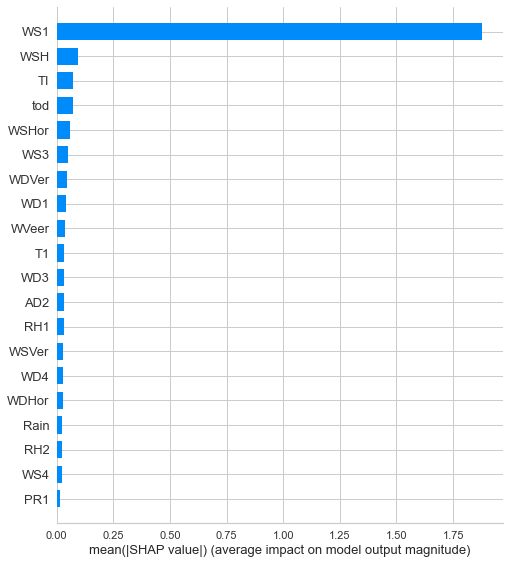

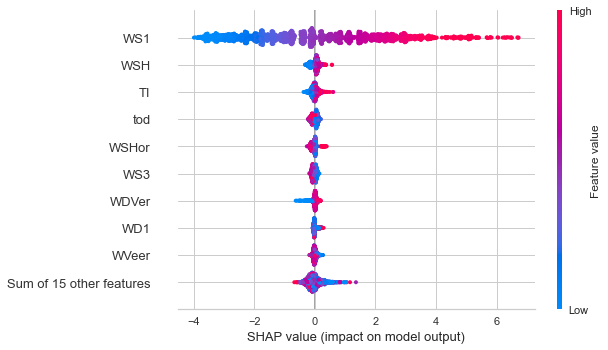

Feature importance through SHAP values performed


In [42]:
shap_values=feature_importance (X_train, X_test, model)

In [43]:
shap_values

,variables,SHAP_abs
0,WS1,1.876430
1,WS3,0.050657
2,WS4,0.023202
3,WSHor,0.058276
4,WDHor,0.027688
5,WSVer,0.029778
6,WDVer,0.044878
7,T1,0.034711
8,RH1,0.030631
9,T2,0.015706


## Dataset3- WTG20

In [29]:
#doing

In [30]:
#upload the dataset with file_folder, file_name
X_train= uploading_csv('\Dataset3-New_Site','\X_train20.csv')
X_test= uploading_csv('\Dataset3-New_Site','\X_test20.csv')
y_train= uploading_csv('\Dataset3-New_Site','\y_train20.csv')
y_test= uploading_csv('\Dataset3-New_Site','\y_test20.csv')

X_test.keys()

Index(['WS1', 'WS3', 'WS4', 'WSHor', 'WDHor', 'WSVer', 'WDVer', 'T1', 'RH1',
       'T2', 'RH2', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WD1', 'WD3', 'WD4',
       'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [31]:
y_test.keys()

Index(['Target'], dtype='object')

In [32]:
PC= uploading_csv('\Dataset3-New_Site','\PC_V150.csv')

### Grid Search

In [48]:
parameters={
    'max_depth':5,
    'n_estimators': 1000,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':1,
    'gamma':0,
    'reg_lambda':1,
}

In [49]:
param_grid={
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
}

In [50]:
 GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 10 candidates, totalling 40 fits

Best parameters :
{'n_estimators': 900}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.039 m/s as root mean
Wind MAE:  0.029 m/s in avg
Wind MAPE:  0.389 %
Power RMSE:  25.255 kW as root mean
Power MAE:  16.949 kW in avg
Power MAPE:  0.984 %

Modelling errors for test set:
Wind RMSE:  0.366 m/s as root mean
Wind MAE:  0.264 m/s in avg
Wind MAPE:  3.452 %
Power RMSE:  221.118 kW as root mean
Power MAE:  145.088 kW in avg
Power MAPE:  8.694 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 3.333031888802846 minutes ---

Lowest RMSE:  0.39574387590349597


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=1000, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,

In [51]:
parameters={
    'max_depth':5,
    'n_estimators': 900,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':1,
    'gamma':0,
    'reg_lambda':1,
}

In [52]:
param_grid={
    'max_depth': [3, 4, 5, 6, 10, 15, 20],
    'min_child_weight': [1, 2, 3, 6, 10]
}

In [53]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 35 candidates, totalling 140 fits

Best parameters :
{'max_depth': 4, 'min_child_weight': 2}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.095 m/s as root mean
Wind MAE:  0.072 m/s in avg
Wind MAPE:  0.957 %
Power RMSE:  62.232 kW as root mean
Power MAE:  41.89 kW in avg
Power MAPE:  2.427 %

Modelling errors for test set:
Wind RMSE:  0.369 m/s as root mean
Wind MAE:  0.267 m/s in avg
Wind MAPE:  3.498 %
Power RMSE:  225.887 kW as root mean
Power MAE:  147.723 kW in avg
Power MAPE:  8.843 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 25.114060819149017 minutes ---

Lowest RMSE:  0.3935615854363187


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=900, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,


In [54]:
parameters={
    'max_depth':4,
    'n_estimators': 900,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':2,
    'gamma':0,
    'reg_lambda':1,
}

In [55]:
param_grid={
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

In [56]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 6 candidates, totalling 24 fits

Best parameters :
{'gamma': 0}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.095 m/s as root mean
Wind MAE:  0.072 m/s in avg
Wind MAPE:  0.957 %
Power RMSE:  62.232 kW as root mean
Power MAE:  41.89 kW in avg
Power MAPE:  2.427 %

Modelling errors for test set:
Wind RMSE:  0.369 m/s as root mean
Wind MAE:  0.267 m/s in avg
Wind MAPE:  3.498 %
Power RMSE:  225.887 kW as root mean
Power MAE:  147.723 kW in avg
Power MAPE:  8.843 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 2.438148339589437 minutes ---

Lowest RMSE:  0.3935615854363187


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=4, min_child_weight=2,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=900, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,


In [57]:
parameters={
    'max_depth':4,
    'n_estimators': 900,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':2,
    'gamma':0,
    'reg_lambda':1,
}

In [58]:
param_grid={
    'subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

In [59]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 49 candidates, totalling 196 fits

Best parameters :
{'colsample_bytree': 0.8, 'subsample': 0.8}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.095 m/s as root mean
Wind MAE:  0.072 m/s in avg
Wind MAPE:  0.957 %
Power RMSE:  62.232 kW as root mean
Power MAE:  41.89 kW in avg
Power MAPE:  2.427 %

Modelling errors for test set:
Wind RMSE:  0.369 m/s as root mean
Wind MAE:  0.267 m/s in avg
Wind MAPE:  3.498 %
Power RMSE:  225.887 kW as root mean
Power MAE:  147.723 kW in avg
Power MAPE:  8.843 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 15.39650328954061 minutes ---

Lowest RMSE:  0.3935615854363187


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=4, min_child_weight=2,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=900, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,


In [60]:
parameters={
    'max_depth':4,
    'n_estimators': 900,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':2,
    'gamma':0,
    'reg_lambda':1,
}

In [61]:
param_grid={
    'reg_lambda': [1, 10, 50, 100, 150]
}

In [62]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 5 candidates, totalling 20 fits

Best parameters :
{'reg_lambda': 1}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.095 m/s as root mean
Wind MAE:  0.072 m/s in avg
Wind MAPE:  0.957 %
Power RMSE:  62.232 kW as root mean
Power MAE:  41.89 kW in avg
Power MAPE:  2.427 %

Modelling errors for test set:
Wind RMSE:  0.369 m/s as root mean
Wind MAE:  0.267 m/s in avg
Wind MAPE:  3.498 %
Power RMSE:  225.887 kW as root mean
Power MAE:  147.723 kW in avg
Power MAPE:  8.843 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 1.8172156969706217 minutes ---

Lowest RMSE:  0.3935615854363187


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=4, min_child_weight=2,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=900, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,


In [63]:
parameters={
    'max_depth':4,
    'n_estimators': 900,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':2,
    'gamma':0,
    'reg_lambda':1,
}

In [64]:
param_grid={
    'learning_rate': [0.001, 0.01, 0.1, 0.5],
    'n_estimators': [800, 900, 1000, 1200, 1500, 1800, 2000]
}

In [65]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 28 candidates, totalling 112 fits

Best parameters :
{'learning_rate': 0.1, 'n_estimators': 900}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.095 m/s as root mean
Wind MAE:  0.072 m/s in avg
Wind MAPE:  0.957 %
Power RMSE:  62.232 kW as root mean
Power MAE:  41.89 kW in avg
Power MAPE:  2.427 %

Modelling errors for test set:
Wind RMSE:  0.369 m/s as root mean
Wind MAE:  0.267 m/s in avg
Wind MAPE:  3.498 %
Power RMSE:  225.887 kW as root mean
Power MAE:  147.723 kW in avg
Power MAPE:  8.843 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 13.571205480893452 minutes ---

Lowest RMSE:  0.3935615854363187


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=4, min_child_weight=2,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=900, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,


### Manual modelling

In [33]:
parameters={
    'max_depth':4,
    'n_estimators': 900,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':2,
    'gamma':0,
    'reg_lambda':1,
}

In [34]:
model = modelling_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.095 m/s as root mean
Wind MAE:  0.072 m/s in avg
Wind MAPE:  0.957 %
Power RMSE:  62.232 kW as root mean
Power MAE:  41.89 kW in avg
Power MAPE:  2.427 %

Modelling errors for test set:
Wind RMSE:  0.369 m/s as root mean
Wind MAE:  0.267 m/s in avg
Wind MAPE:  3.498 %
Power RMSE:  225.887 kW as root mean
Power MAE:  147.723 kW in avg
Power MAPE:  8.843 %


Showing the results of the modelling: 
XGBoost modelling performed


### Model testing

In [35]:
WS_pred=model_testing (X_train, X_test, y_train, y_test, PC, model, plot_error=False)

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.095 m/s as root mean
Wind MAE:  0.072 m/s in avg
Wind MAPE:  0.957 %
Power RMSE:  62.232 kW as root mean
Power MAE:  41.89 kW in avg
Power MAPE:  2.427 %

Modelling errors for test set:
Wind RMSE:  0.369 m/s as root mean
Wind MAE:  0.267 m/s in avg
Wind MAPE:  3.498 %
Power RMSE:  225.887 kW as root mean
Power MAE:  147.723 kW in avg
Power MAPE:  8.843 %


Showing the results of the modelling: 
XGBoost results performed


In [36]:
WS_pred=pd.DataFrame(WS_pred)
save(WS_pred,'\Results_','XGB_WTG20.csv')

file XGB_WTG20.csv saved in \Results_ folder


### Feature importance

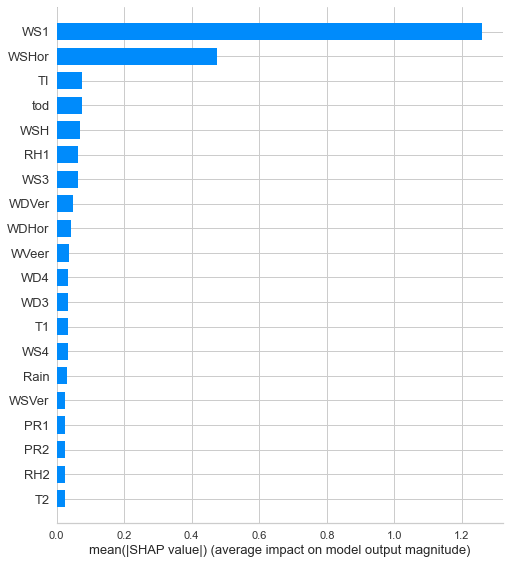

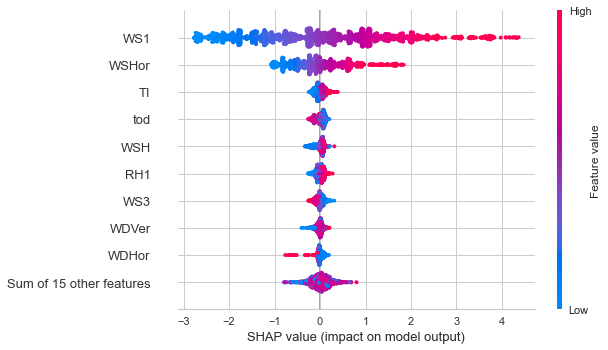

Feature importance through SHAP values performed


In [68]:
shap_values=feature_importance (X_train, X_test, model)

In [69]:
shap_values

,variables,SHAP_abs
0,WS1,1.259104
1,WS3,0.061999
2,WS4,0.033022
3,WSHor,0.474784
4,WDHor,0.041982
5,WSVer,0.026314
6,WDVer,0.047682
7,T1,0.033310
8,RH1,0.064336
9,T2,0.023860


## Dataset3- WTG43

In [37]:
#upload the dataset with file_folder, file_name
X_train= uploading_csv('\Dataset3-New_Site','\X_train43.csv')
X_test= uploading_csv('\Dataset3-New_Site','\X_test43.csv')
y_train= uploading_csv('\Dataset3-New_Site','\y_train43.csv')
y_test= uploading_csv('\Dataset3-New_Site','\y_test43.csv')

X_test.keys()

Index(['WS1', 'WS3', 'WS4', 'WSHor', 'WDHor', 'WSVer', 'WDVer', 'T1', 'RH1',
       'T2', 'RH2', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WD1', 'WD3', 'WD4',
       'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [38]:
y_test.keys()

Index(['Target'], dtype='object')

In [39]:
PC= uploading_csv('\Dataset3-New_Site','\PC_V150.csv')

### Grid Search

In [25]:
parameters={
    'max_depth':5,
    'n_estimators': 1000,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':1,
    'gamma':0,
    'reg_lambda':1,
}

In [26]:
param_grid={
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
}

In [27]:
 GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 10 candidates, totalling 40 fits

Best parameters :
{'n_estimators': 900}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.062 m/s as root mean
Wind MAE:  0.047 m/s in avg
Wind MAPE:  0.577 %
Power RMSE:  36.627 kW as root mean
Power MAE:  22.4 kW in avg
Power MAPE:  1.289 %

Modelling errors for test set:
Wind RMSE:  0.457 m/s as root mean
Wind MAE:  0.335 m/s in avg
Wind MAPE:  4.052 %
Power RMSE:  247.223 kW as root mean
Power MAE:  146.449 kW in avg
Power MAPE:  9.104 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 6.131625286738077 minutes ---

Lowest RMSE:  0.45965929085478197


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=1000, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,

In [28]:
parameters={
    'max_depth':5,
    'n_estimators': 900,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':1,
    'gamma':0,
    'reg_lambda':1,
}

In [29]:
param_grid={
    'max_depth': [3, 4, 5, 6, 10, 15, 20],
    'min_child_weight': [1, 2, 3, 6, 10]
}

In [30]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 35 candidates, totalling 140 fits

Best parameters :
{'max_depth': 10, 'min_child_weight': 10}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.002 m/s as root mean
Wind MAE:  0.002 m/s in avg
Wind MAPE:  0.021 %
Power RMSE:  1.465 kW as root mean
Power MAE:  0.786 kW in avg
Power MAPE:  0.045 %

Modelling errors for test set:
Wind RMSE:  0.45 m/s as root mean
Wind MAE:  0.328 m/s in avg
Wind MAPE:  3.966 %
Power RMSE:  244.439 kW as root mean
Power MAE:  144.56 kW in avg
Power MAPE:  8.89 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 37.80744110743205 minutes ---

Lowest RMSE:  0.4551632424348052


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=900, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,


In [31]:
parameters={
    'max_depth':10,
    'n_estimators': 900,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':10,
    'gamma':0,
    'reg_lambda':1,
}

In [32]:
param_grid={
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

In [33]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 6 candidates, totalling 24 fits

Best parameters :
{'gamma': 0}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.002 m/s as root mean
Wind MAE:  0.002 m/s in avg
Wind MAPE:  0.021 %
Power RMSE:  1.465 kW as root mean
Power MAE:  0.786 kW in avg
Power MAPE:  0.045 %

Modelling errors for test set:
Wind RMSE:  0.45 m/s as root mean
Wind MAE:  0.328 m/s in avg
Wind MAPE:  3.966 %
Power RMSE:  244.439 kW as root mean
Power MAE:  144.56 kW in avg
Power MAPE:  8.89 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 12.98054697116216 minutes ---

Lowest RMSE:  0.4551632424348052


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=10, min_child_weight=10,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=900, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None

In [34]:
parameters={
    'max_depth':10,
    'n_estimators': 900,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':10,
    'gamma':0,
    'reg_lambda':1,
}

In [35]:
param_grid={
    'subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

In [36]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 49 candidates, totalling 196 fits

Best parameters :
{'colsample_bytree': 0.6, 'subsample': 0.6}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.004 m/s as root mean
Wind MAE:  0.003 m/s in avg
Wind MAPE:  0.036 %
Power RMSE:  2.453 kW as root mean
Power MAE:  1.388 kW in avg
Power MAPE:  0.079 %

Modelling errors for test set:
Wind RMSE:  0.442 m/s as root mean
Wind MAE:  0.329 m/s in avg
Wind MAPE:  3.964 %
Power RMSE:  239.416 kW as root mean
Power MAE:  144.504 kW in avg
Power MAPE:  8.786 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 54.723526354630785 minutes ---

Lowest RMSE:  0.4505266994150377


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=10, min_child_weight=10,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=900, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None

In [38]:
parameters={
    'max_depth':10,
    'n_estimators': 900,
    'learning_rate':0.1,
    'subsample':0.6,
    'colsample_bytree':0.6,
    'min_child_weight':10,
    'gamma':0,
    'reg_lambda':1,
}

In [39]:
param_grid={
    'reg_lambda': [1, 10, 50, 100, 150]
}

In [40]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 5 candidates, totalling 20 fits

Best parameters :
{'reg_lambda': 10}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.01 m/s as root mean
Wind MAE:  0.007 m/s in avg
Wind MAPE:  0.084 %
Power RMSE:  5.603 kW as root mean
Power MAE:  3.16 kW in avg
Power MAPE:  0.182 %

Modelling errors for test set:
Wind RMSE:  0.437 m/s as root mean
Wind MAE:  0.325 m/s in avg
Wind MAPE:  3.936 %
Power RMSE:  240.07 kW as root mean
Power MAE:  144.576 kW in avg
Power MAPE:  8.85 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 4.2366370479265845 minutes ---

Lowest RMSE:  0.449929361421265


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.6,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=10, min_child_weight=10,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=900, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.6,
                                    tree_method=None, validate_parameters=None

In [41]:
parameters={
    'max_depth':10,
    'n_estimators': 900,
    'learning_rate':0.1,
    'subsample':0.6,
    'colsample_bytree':0.6,
    'min_child_weight':10,
    'gamma':0,
    'reg_lambda':10,
}

In [42]:
param_grid={
    'learning_rate': [0.001, 0.01, 0.1, 0.5],
    'n_estimators': [800, 900, 1000, 1200, 1500, 1800, 2000]
}

In [43]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 28 candidates, totalling 112 fits

Best parameters :
{'learning_rate': 0.01, 'n_estimators': 2000}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.15 m/s as root mean
Wind MAE:  0.109 m/s in avg
Wind MAPE:  1.333 %
Power RMSE:  85.819 kW as root mean
Power MAE:  50.891 kW in avg
Power MAPE:  2.994 %

Modelling errors for test set:
Wind RMSE:  0.431 m/s as root mean
Wind MAE:  0.319 m/s in avg
Wind MAPE:  3.844 %
Power RMSE:  234.373 kW as root mean
Power MAE:  139.844 kW in avg
Power MAPE:  8.586 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 22.756420926253 minutes ---

Lowest RMSE:  0.44592468426799825


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.6,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=10, min_child_weight=10,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=900, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=10,
                                    scale_pos_weight=None, subsample=0.6,
                                    tree_method=None, validate_parameters=Non

### Manual modelling

In [40]:
parameters={
    'max_depth':10,
    'n_estimators': 2000,
    'learning_rate':0.01,
    'subsample':0.6,
    'colsample_bytree':0.6,
    'min_child_weight':10,
    'gamma':0,
    'reg_lambda':10,
}

In [41]:
model = modelling_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.15 m/s as root mean
Wind MAE:  0.109 m/s in avg
Wind MAPE:  1.333 %
Power RMSE:  85.819 kW as root mean
Power MAE:  50.891 kW in avg
Power MAPE:  2.994 %

Modelling errors for test set:
Wind RMSE:  0.431 m/s as root mean
Wind MAE:  0.319 m/s in avg
Wind MAPE:  3.844 %
Power RMSE:  234.373 kW as root mean
Power MAE:  139.844 kW in avg
Power MAPE:  8.586 %


Showing the results of the modelling: 
XGBoost modelling performed


### Model testing

In [42]:
WS_pred=model_testing (X_train, X_test, y_train, y_test, PC, model, plot_error=False)

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.15 m/s as root mean
Wind MAE:  0.109 m/s in avg
Wind MAPE:  1.333 %
Power RMSE:  85.819 kW as root mean
Power MAE:  50.891 kW in avg
Power MAPE:  2.994 %

Modelling errors for test set:
Wind RMSE:  0.431 m/s as root mean
Wind MAE:  0.319 m/s in avg
Wind MAPE:  3.844 %
Power RMSE:  234.373 kW as root mean
Power MAE:  139.844 kW in avg
Power MAPE:  8.586 %


Showing the results of the modelling: 
XGBoost results performed


In [43]:
WS_pred=pd.DataFrame(WS_pred)
save(WS_pred,'\Results_','XGB_WTG43.csv')

file XGB_WTG43.csv saved in \Results_ folder


### Feature importance

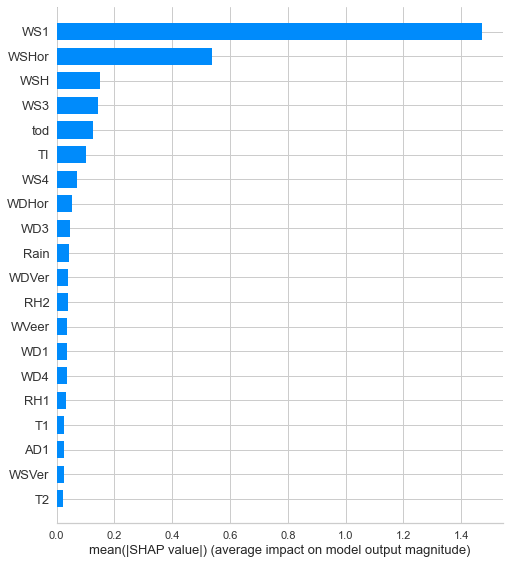

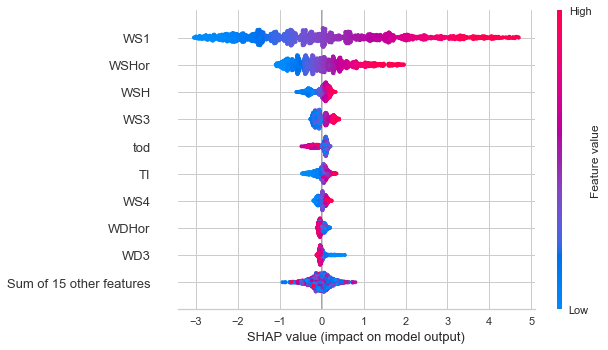

Feature importance through SHAP values performed


In [47]:
shap_values=feature_importance (X_train, X_test, model)

In [48]:
shap_values

,variables,SHAP_abs
0,WS1,1.471092
1,WS3,0.143570
2,WS4,0.069411
3,WSHor,0.536350
4,WDHor,0.053539
5,WSVer,0.024725
6,WDVer,0.039164
7,T1,0.027184
8,RH1,0.032035
9,T2,0.023011


## Dataset3- WTG46

In [44]:
#upload the dataset with file_folder, file_name
X_train= uploading_csv('\Dataset3-New_Site','\X_train46.csv')
X_test= uploading_csv('\Dataset3-New_Site','\X_test46.csv')
y_train= uploading_csv('\Dataset3-New_Site','\y_train46.csv')
y_test= uploading_csv('\Dataset3-New_Site','\y_test46.csv')

X_test.keys()

Index(['WS1', 'WS3', 'WS4', 'WSHor', 'WDHor', 'WSVer', 'WDVer', 'T1', 'RH1',
       'T2', 'RH2', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WD1', 'WD3', 'WD4',
       'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [45]:
y_test.keys()

Index(['Target'], dtype='object')

In [46]:
PC= uploading_csv('\Dataset3-New_Site','\PC_V150.csv')

### Grid Search

In [52]:
parameters={
    'max_depth':5,
    'n_estimators': 1000,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':1,
    'gamma':0,
    'reg_lambda':1,
}

In [53]:
param_grid={
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
}

In [54]:
 GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 10 candidates, totalling 40 fits

Best parameters :
{'n_estimators': 600}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.082 m/s as root mean
Wind MAE:  0.062 m/s in avg
Wind MAPE:  0.852 %
Power RMSE:  52.22 kW as root mean
Power MAE:  34.669 kW in avg
Power MAPE:  2.269 %

Modelling errors for test set:
Wind RMSE:  0.342 m/s as root mean
Wind MAE:  0.243 m/s in avg
Wind MAPE:  3.404 %
Power RMSE:  208.297 kW as root mean
Power MAE:  132.974 kW in avg
Power MAPE:  9.291 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 6.337219214439392 minutes ---

Lowest RMSE:  0.34491121389593976


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=1000, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,

In [55]:
parameters={
    'max_depth':5,
    'n_estimators': 600,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':1,
    'gamma':0,
    'reg_lambda':1,
}

In [56]:
param_grid={
    'max_depth': [3, 4, 5, 6, 10, 15, 20],
    'min_child_weight': [1, 2, 3, 6, 10]
}

In [57]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 35 candidates, totalling 140 fits

Best parameters :
{'max_depth': 5, 'min_child_weight': 3}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.087 m/s as root mean
Wind MAE:  0.066 m/s in avg
Wind MAPE:  0.902 %
Power RMSE:  55.483 kW as root mean
Power MAE:  36.896 kW in avg
Power MAPE:  2.403 %

Modelling errors for test set:
Wind RMSE:  0.338 m/s as root mean
Wind MAE:  0.238 m/s in avg
Wind MAPE:  3.319 %
Power RMSE:  205.459 kW as root mean
Power MAE:  129.569 kW in avg
Power MAPE:  9.005 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 19.586459314823152 minutes ---

Lowest RMSE:  0.34344046036205395


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=600, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,


In [59]:
parameters={
    'max_depth':5,
    'n_estimators': 600,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':3,
    'gamma':0,
    'reg_lambda':1,
}

In [60]:
param_grid={
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

In [61]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 6 candidates, totalling 24 fits

Best parameters :
{'gamma': 0}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.087 m/s as root mean
Wind MAE:  0.066 m/s in avg
Wind MAPE:  0.902 %
Power RMSE:  55.483 kW as root mean
Power MAE:  36.896 kW in avg
Power MAPE:  2.403 %

Modelling errors for test set:
Wind RMSE:  0.338 m/s as root mean
Wind MAE:  0.238 m/s in avg
Wind MAPE:  3.319 %
Power RMSE:  205.459 kW as root mean
Power MAE:  129.569 kW in avg
Power MAPE:  9.005 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 2.2791846712430317 minutes ---

Lowest RMSE:  0.34344046036205395


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=3,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=600, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,


In [62]:
parameters={
    'max_depth':5,
    'n_estimators': 600,
    'learning_rate':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':3,
    'gamma':0,
    'reg_lambda':1,
}

In [63]:
param_grid={
    'subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

In [64]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 49 candidates, totalling 196 fits

Best parameters :
{'colsample_bytree': 1, 'subsample': 0.7}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.084 m/s as root mean
Wind MAE:  0.064 m/s in avg
Wind MAPE:  0.876 %
Power RMSE:  53.783 kW as root mean
Power MAE:  35.895 kW in avg
Power MAPE:  2.339 %

Modelling errors for test set:
Wind RMSE:  0.334 m/s as root mean
Wind MAE:  0.236 m/s in avg
Wind MAPE:  3.294 %
Power RMSE:  202.4 kW as root mean
Power MAE:  128.373 kW in avg
Power MAPE:  8.959 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 19.885001428922017 minutes ---

Lowest RMSE:  0.34224919499792844


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=3,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=600, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,


In [65]:
parameters={
    'max_depth':5,
    'n_estimators': 600,
    'learning_rate':0.1,
    'subsample':0.7,
    'colsample_bytree':1,
    'min_child_weight':3,
    'gamma':0,
    'reg_lambda':1,
}

In [66]:
param_grid={
    'reg_lambda': [1, 10, 50, 100, 150]
}

In [67]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 5 candidates, totalling 20 fits

Best parameters :
{'reg_lambda': 1}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.084 m/s as root mean
Wind MAE:  0.064 m/s in avg
Wind MAPE:  0.876 %
Power RMSE:  53.783 kW as root mean
Power MAE:  35.895 kW in avg
Power MAPE:  2.339 %

Modelling errors for test set:
Wind RMSE:  0.334 m/s as root mean
Wind MAE:  0.236 m/s in avg
Wind MAPE:  3.294 %
Power RMSE:  202.4 kW as root mean
Power MAE:  128.373 kW in avg
Power MAPE:  8.959 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 3.0368500630060833 minutes ---

Lowest RMSE:  0.34224919499792844


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=1,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=3,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=600, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.7,
                                    tree_method=None, validate_parameters=None,
  

In [25]:
parameters={
    'max_depth':5,
    'n_estimators': 600,
    'learning_rate':0.1,
    'subsample':0.7,
    'colsample_bytree':1,
    'min_child_weight':3,
    'gamma':0,
    'reg_lambda':1,
}

In [26]:
param_grid={
    'learning_rate': [0.001, 0.01, 0.1, 0.5],
    'n_estimators': [800, 900, 1000, 1200, 1500, 1800, 2000]
}

In [27]:
GridSearch_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, param_grid, plot_error=False)

Fitting 4 folds for each of 28 candidates, totalling 112 fits

Best parameters :
{'learning_rate': 0.01, 'n_estimators': 2000}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.189 m/s as root mean
Wind MAE:  0.142 m/s in avg
Wind MAPE:  1.96 %
Power RMSE:  119.965 kW as root mean
Power MAE:  78.914 kW in avg
Power MAPE:  5.277 %

Modelling errors for test set:
Wind RMSE:  0.335 m/s as root mean
Wind MAE:  0.239 m/s in avg
Wind MAPE:  3.332 %
Power RMSE:  204.484 kW as root mean
Power MAE:  131.071 kW in avg
Power MAPE:  9.106 %


Showing the results of the modelling: 
GridSearch_ XGBoost performed
--- 24.649036407470703 minutes ---

Lowest RMSE:  0.34107768715526765


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=1,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=3,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=600, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=1,
                                    scale_pos_weight=None, subsample=0.7,
                                    tree_method=None, validate_parameters=None,
  

### Manual modelling

In [47]:
parameters={
    'max_depth':5,
    'n_estimators': 2000,
    'learning_rate':0.01,
    'subsample':0.7,
    'colsample_bytree':1,
    'min_child_weight':3,
    'gamma':0,
    'reg_lambda':1,
}

In [48]:
model = modelling_XGBoost (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.189 m/s as root mean
Wind MAE:  0.142 m/s in avg
Wind MAPE:  1.96 %
Power RMSE:  119.965 kW as root mean
Power MAE:  78.914 kW in avg
Power MAPE:  5.277 %

Modelling errors for test set:
Wind RMSE:  0.335 m/s as root mean
Wind MAE:  0.239 m/s in avg
Wind MAPE:  3.332 %
Power RMSE:  204.484 kW as root mean
Power MAE:  131.071 kW in avg
Power MAPE:  9.106 %


Showing the results of the modelling: 
XGBoost modelling performed


### Model testing

In [49]:
WS_pred=model_testing (X_train, X_test, y_train, y_test, PC, model, plot_error=False)

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.189 m/s as root mean
Wind MAE:  0.142 m/s in avg
Wind MAPE:  1.96 %
Power RMSE:  119.965 kW as root mean
Power MAE:  78.914 kW in avg
Power MAPE:  5.277 %

Modelling errors for test set:
Wind RMSE:  0.335 m/s as root mean
Wind MAE:  0.239 m/s in avg
Wind MAPE:  3.332 %
Power RMSE:  204.484 kW as root mean
Power MAE:  131.071 kW in avg
Power MAPE:  9.106 %


Showing the results of the modelling: 
XGBoost results performed


In [50]:
WS_pred=pd.DataFrame(WS_pred)
save(WS_pred,'\Results_','XGB_WTG46.csv')

file XGB_WTG46.csv saved in \Results_ folder


### Feature importance

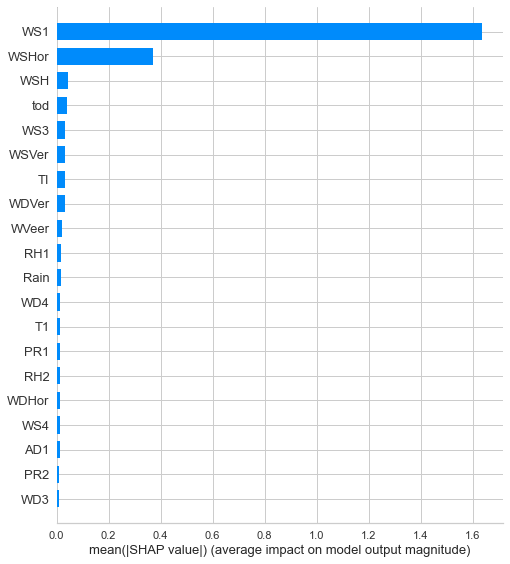

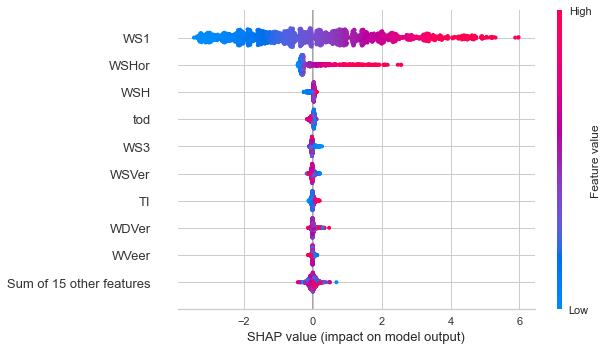

Feature importance through SHAP values performed


In [30]:
shap_values=feature_importance (X_train, X_test, model)

In [31]:
shap_values

,variables,SHAP_abs
0,WS1,1.635097
1,WS3,0.034228
2,WS4,0.012388
3,WSHor,0.370225
4,WDHor,0.012498
5,WSVer,0.033881
6,WDVer,0.031748
7,T1,0.014431
8,RH1,0.018593
9,T2,0.009620
